<div class="alert alert-block alert-info">
<b>Deadline:</b> May 8, 2024 (Wednesday) 23:00
</div>

# Exercise 1. Denoising Diffusion Probabilistic Models (DDPM)

The goal of this exercise is to get familiar with diffusion-based generative models using the DDPM model as an example. The model is proposed in [this paper](https://arxiv.org/pdf/2006.11239.pdf).

**This exercise requires a significant amount of computing power, you need to use a GPU.**

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import time
import matplotlib.pyplot as plt
import numpy as np
import random

import torch
import torchvision
import torchvision.utils as utils
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import fd

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is ../data


In [5]:
# Select the device for training (use GPU if you have one)
device = torch.device('cpu')
#device = torch.device('cuda:0')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device('cpu')

# Data

In this exercise, we use standard MNIST data. To simplify the construction of the denoising model (U-net), we upscale the images to $32\times 32$ resolution.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Resize((32, 32)),
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

#trainset = datasets.MNIST(root='../data/', train=True, download=True, transform=transform,)
trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

torch.Size([128, 1, 32, 32])


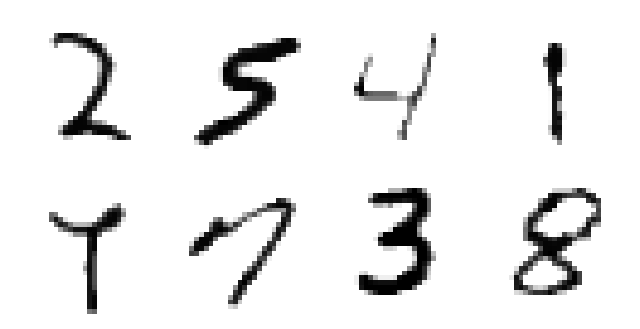

In [8]:
images, labels = next(iter(trainloader))
print(images.shape)
tools.show_images(images[:8], ncol=4, cmap='binary', clim=[0,1])

# Diffusion model

In DDPM, the forward process (or diffusion process) is a Markov chain that gradually adds Gaussian noise to the data according to a variance schedule $\beta_1, ..., \beta_T$:
$$
q(x_{1:T} | x_0) = \prod^T_{t=1} q(x_t|x_{t−1}), q(x_t|x_{t−1}) = N (x_t; \sqrt{1 − \beta_t} x_{t−1}, \beta_t I)
$$

* In our implementation of DDPM, we use a linear schedule for $\beta_t$ that grows linearly from 0.0001 to 0.02 with T=1000 time steps in total. Please store the values of $\beta_t$ in attribute `self.betas`.

* We implement the forward diffusion process in function `forward()`. This function receives a clearn sample $x_0$ and a noise instance $\epsilon_t$ and returns
$$
x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon_t
$$
which is a sample from the following distribution:
$$
q(x_t|x_0) = N(x_t; \sqrt{\bar{\alpha}_t} x_{0}, (1 - \bar{\alpha}_t) I)
$$
where
$$
\bar{\alpha}_t = \prod^t_{s=1} \alpha_s
\qquad
\alpha_t = 1 − \beta_t.
$$
Note that the denoising model is trained to predict the noise instance $\epsilon_t$ which is why we create it outside of the function.

* Samples are generated with an inverse diffusion process which we implement in function `sample()`. The sampling process is described in Algorithm 2 of the paper:
<img src="alg_sampling.png" width=350>
where $\sigma_t = \sqrt{\beta_t}$.

Notes:
* **In this exercise, we do not condition our generative model on the class information (the classes of digits). Therefore, we expect argument `labels` to be `None`. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.**

In [9]:
class Diffusion(nn.Module):
    """Diffusion model with a linear schedule of the temperatures.
    """
    def __init__(self, num_timesteps=1000):
        super(Diffusion, self).__init__()
        self.betas = torch.linspace(0.0001, 0.02, num_timesteps)
        self.num_timesteps = num_timesteps

    def forward(self, x, t, noise=None):
        """
        Args:
          x of shape (batch_size, ...): Input samples.
          t of shape (batch_size,): Corruption temperatures.
          noise of shape (batch_size, ...): Noise instanses used for corruption.
        """
        batch_size = x.shape[0]
        if noise is None:
            noise = torch.zeros_like(x)
        ret = torch.zeros_like(x).to(x.device)
        for i in range(batch_size):
            alpha_bar = torch.prod(1 - self.betas[:t[i] + 1])
            ret[i] = torch.sqrt(alpha_bar) * x[i] + torch.sqrt(1 - alpha_bar) * noise[i]

        return ret

    @torch.no_grad()
    def sample(self, model, x_shape, labels=None):
        """
        Args:
          model: A denoising model. model(x, t, labels) takes as inputs:
                   x of shape (batch_size, n_channels, H, W): corrupted examples.
                   t of shape (batch_size,): LongTensor of time steps.
                   labels of shape (batch_size,): LongTensor of the classes of the examples in x.
                 and outputs a denoised version of input x.
          x_shape: The shape of the generated data. For example, to generate batch_size images of shape (1, H, W),
                   x_shape should be (batch_size, 1, H, W).
          labels of shape (batch_size,): LongTensor of the classes of generated samples. None for no conditioning
                   on classes.
        
        Note: Create new tensors on the same device where the model is.
        """
        batch_size = x_shape[0]
        ret = torch.randn(x_shape).to(device)

        for t in reversed(range(self.num_timesteps)):
            noise = torch.randn(x_shape) if t > 0 else torch.zeros(x_shape)
            noise = noise.to(device)

            alpha_bar = torch.prod(1 - self.betas[:t+1]).to(device)
            
            time_steps = torch.full((batch_size,), t, device=device, dtype=torch.long)
            output = model.forward(ret, time_steps, labels)
            
            ret =  1 / torch.sqrt(1 - self.betas[t]) * (ret - self.betas[t] * output / torch.sqrt(1 - alpha_bar)) + torch.sqrt(self.betas[t]) * noise
        return ret

In [10]:
diffusion = Diffusion(1000)
assert diffusion.betas[0] == 1e-4, "The lowest temperature should be 1e-4"
assert diffusion.betas[-1] == 0.02, "The highest temperature should be 0.02"
assert len(diffusion.betas) == 1000, "The number of steps should be 1000"

def test_diffusion_forward_shapes():
    diffusion = Diffusion(1000)
    batch_size = 2
    x = torch.randn(batch_size, 1, 32, 32)
    t = torch.LongTensor([500, 900])
    
    out = diffusion.forward(x, t)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"

    noise = torch.randn_like(x)
    out = diffusion.forward(x, t, noise)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_diffusion_forward_shapes()

Success


In [11]:
def test_diffusion_forward():
    diffusion = Diffusion(1000)
    batch_size = 2
    x = 2 * torch.ones(batch_size, 1, 32, 32)
    t = torch.LongTensor([500, 900])
    noise = torch.ones_like(x)
    out = diffusion.forward(x, t, noise)
    expected = torch.empty_like(x)
    expected[0].fill_(1.51815533)
    expected[1].fill_(1.03274309)

    print('out:\n', out)
    print('expected correct:\n', expected)
    assert torch.allclose(expected, out), "out does not match the expected value."
    print('Success')

out = test_diffusion_forward()

out:
 tensor([[[[1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          ...,
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182]]],


        [[[1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          ...,
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327],
          [1.0327, 1.0327, 1.0327,  ..., 1.0327, 1.0327, 1.0327]]]])
expected correct:
 tensor([[[[1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5182, 1.5182, 1.5182,  ..., 1.5182, 1.5182, 1.5182],
          [1.5

In [12]:
class DummyModel(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, t, labels=None):
        return x

def test_diffusion_sample_shapes():
    diffusion = Diffusion(1000)
    batch_size = 2
    x_shape = (batch_size, 1, 32, 32)
    model = DummyModel()
    
    out = diffusion.sample(model, x_shape, labels=None)
    assert out.shape == x_shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_diffusion_sample_shapes()

Success


In [13]:
import unittest.mock

def my_randn_like(x):
    return torch.ones_like(x)

def my_randn(*args, **kwargs):
    return torch.ones(*args, **kwargs)

def my_normal(mean, std, **kwargs):
    return mean + std * torch.ones_like(std)

@unittest.mock.patch('torch.randn_like', my_randn_like)
@unittest.mock.patch('torch.randn', my_randn)
@unittest.mock.patch('torch.normal', my_normal)
def test_diffusion_sample():
    diffusion = Diffusion(10)
    model = DummyModel()
    batch_size = 2
    x_shape = (batch_size, 1, 32, 32)

    out = diffusion.sample(model, x_shape, labels=None)
    expected = torch.empty(x_shape).fill_(1.3058254)
    print('out:\n', out)
    print('expected correct:\n', expected)
    assert torch.allclose(expected, out), "out does not match the expected value."
    print('Success')

test_diffusion_sample()

out:
 tensor([[[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          ...,
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058]]],


        [[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          ...,
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058]]]])
expected correct:
 tensor([[[[1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3058, 1.3058, 1.3058,  ..., 1.3058, 1.3058, 1.3058],
          [1.3

We can visualize the forward process in the cell below. Note that since `Diffusion.forward()` samples independent noise instances for different time steps $t$, the illustration below does **not** correspond to steps of the same diffusion process.

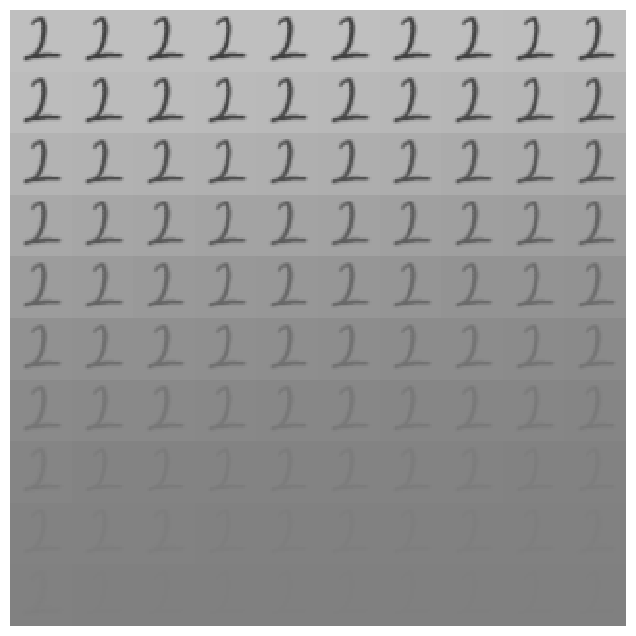

In [14]:
diffusion = Diffusion(1000)
t = torch.arange(0, diffusion.num_timesteps, 10)
x, _ = random.choice(trainset)
x = x[None, ...].tile(len(t), 1, 1, 1)  # (t_steps, c, h, w)

x_perturbed = diffusion.forward(x, t)
tools.show_images(x_perturbed, ncol=10, cmap='binary', clim=[-2, 2])

## Construct the denoising model

A denoising model is the model that predicts the noise instance $\epsilon$
$$
  \epsilon = f(\tilde{x}, t, y)
$$
that was used to generate the corrupted sample $\tilde{x}$ with the corruption level defined by time step $t$. For denoising conditioned on label $y$, the model additionally accepts the label information $y$ (optional). 

The output $\epsilon$ of the model should have the same dimensionality as the input $\tilde{x}$. The architecture that is very commonly used for $f$ is a U-net.

We are not testing the architecture of the U-net in this notebook but the following architecture worked for us:
* The model uses blocks `ResidualBlock`, `Downsample` and `PositionalEmbedding` defined in `blocks.py`.
* To enable conditioning on time step $t$, we encode the time step using an MLP that is a sequence of the following layers:
  * `PositionalEmbedding` with `base_channels` outputs
  * `Linear` layer with `time_emb_dim` outputs
  * `SiLU` nonlinearity
  * `Linear` layer with `time_emb_dim` outputs
  
* The encoder is a sequence of the following blocks:
  * A convolutional layer with 3x3 kernel, `base_channels` output channels, which keeps the resolution of the input.
  * `ResidualBlock` with `base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Downsample` layer which preserves the number of channels.
  * `ResidualBlock` with `2*base_channels` output channels.

* The encoder is followed by a bottleneck layer which is
  * `ResidualBlock` with `2*base_channels` output channels.
  
* The decoder is a sequence of the following blocks:
  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `2*base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `2*base_channels` output channels.
  * `ResidualBlock` with `base_channels` output channels.
  * `Upsample` layer which preserves the number of channels.

  * `ResidualBlock` with `base_channels` output channels.
  * `ResidualBlock` with `base_channels` output channels.
  * A convolutional layer with 3x3 kernel, `img_channels` output channels, which keeps the resolution of the input.
  
**Notes:**

* Each residual block receives the time-step embedding produced by the MLP defined above and the label of a sample as extra inputs.
  
* The inputs of the decoder residual blocks are concatenations of two signals: the output of the previous decoder layer and the skip signal produced by the corresponding layer of the encoder.

* There are 8 skip signals in totals: they are the outputs of the first convolutional layer and the encoder blocks of type `ResidualBlock` and `Downsample`.

* `Upsample` layers of the decoder do not receive skip signals.

* **In this exercise, we do not condition our generative model on the class information (the classes of digits). Therefore, we expect argument `num_classes` to be `None`. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.**

In [15]:
from blocks import ResidualBlock, Downsample, Upsample, PositionalEmbedding


class UNet(nn.Module):
    """The denoising model.
    
    Args:
      img_channels (int): Number of image channels.
      base_channels (int): Number of base channels.
      time_emb_dim (int or None): The size of the embedding vector produced by the MLP which embeds the time input.
      num_classes (int or None): Number of classes, None for no conditioning on classes.
    """

    def __init__(self, img_channels, base_channels, time_emb_dim=None, num_classes=None):
        super(UNet, self).__init__()

        self.mlp = nn.Sequential(
            PositionalEmbedding(base_channels),
            nn.Linear(base_channels, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        
        self.encoder1 = nn.Conv2d(img_channels, base_channels, 3, padding=1)
        self.encoder2 = ResidualBlock(base_channels, base_channels, time_emb_dim, num_classes)
        self.encoder3 = Downsample(base_channels)
        self.encoder4 = ResidualBlock(base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.encoder5 = Downsample(2 * base_channels)
        self.encoder6 = ResidualBlock(2 * base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.encoder7 = Downsample(2 * base_channels)
        self.encoder8 = ResidualBlock(2 * base_channels, 2 * base_channels, time_emb_dim, num_classes)

        self.bottleneck = ResidualBlock(2 * base_channels, 2 * base_channels, time_emb_dim, num_classes)

        
        self.decoder1 = ResidualBlock(4 * base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.decoder2 = ResidualBlock(4 * base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.decoder3 = Upsample(2 * base_channels)
        self.decoder4 = ResidualBlock(4 * base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.decoder5 = ResidualBlock(4 * base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.decoder6 = Upsample(2 * base_channels)
        self.decoder7 = ResidualBlock(4 * base_channels, 2 * base_channels, time_emb_dim, num_classes)
        self.decoder8 = ResidualBlock(3 * base_channels, base_channels, time_emb_dim, num_classes)
        self.decoder9 = Upsample(base_channels)
        self.decoder10 = ResidualBlock(2 * base_channels, base_channels, time_emb_dim, num_classes)
        self.decoder11 = ResidualBlock(2 * base_channels, base_channels, time_emb_dim, num_classes)
        self.decoder12 = nn.Conv2d(base_channels, img_channels, 3, padding=1)
        

    
    def forward(self, x, time=None, labels=None):
        """Estimate noise instances used to produced corrupted examples `x` with the corruption level determined
        by `time`. `labels` contains the class information of the examples in `x`.

        Args:
          x of shape (batch_size, n_channels, H, W): Corrupted examples.
          time of shape (batch_size,): LongTensor of time steps which determine the corruption level for
                                       the examples in x.
          labels of shape (batch_size,): LongTensor of the classes of the examples in x.
        
        Returns:
          out of shape (batch_size, n_channels, H, W)
        """
        conditioning = self.mlp(time) if time is not None else None
            
        encoder_output_1 = self.encoder1(x)
        encoder_output_2 = self.encoder2(encoder_output_1, conditioning, labels)
        encoder_output_3 = self.encoder3(encoder_output_2)
        encoder_output_4 = self.encoder4(encoder_output_3, conditioning, labels)
        encoder_output_5 = self.encoder5(encoder_output_4)
        encoder_output_6 = self.encoder6(encoder_output_5, conditioning, labels)
        encoder_output_7 = self.encoder7(encoder_output_6)
        encoder_output_8 = self.encoder8(encoder_output_7, conditioning, labels)

        output = self.bottleneck(encoder_output_8, conditioning, labels)

        output = self.decoder1(torch.cat((output, encoder_output_8), dim=1), conditioning, labels)
        output = self.decoder2(torch.cat((output, encoder_output_7), dim=1), conditioning, labels)
        output = self.decoder3(output)
        output = self.decoder4(torch.cat((output, encoder_output_6), dim=1), conditioning, labels)
        output = self.decoder5(torch.cat((output, encoder_output_5), dim=1), conditioning, labels)
        output = self.decoder6(output)
        output = self.decoder7(torch.cat((output, encoder_output_4), dim=1), conditioning, labels)
        output = self.decoder8(torch.cat((output, encoder_output_3), dim=1), conditioning, labels)
        output = self.decoder9(output)
        output = self.decoder10(torch.cat((output, encoder_output_2), dim=1), conditioning, labels)
        output = self.decoder11(torch.cat((output, encoder_output_1), dim=1), conditioning, labels)
        output = self.decoder12(output)

        return output
        

In [16]:
def test_UNet_shapes():
    unet = UNet(
        img_channels=1,
        base_channels=128,
        time_emb_dim=32,
        num_classes=None,
    )

    batch_size = 3
    x = torch.randn(batch_size, 1, 32, 32)
    t = torch.LongTensor([0, 1, 2])
    labels = None
    out = unet(x, t, labels)
    assert out.shape == x.shape, f"Bad out.shape: {out.shape}"
    print('Success')

test_UNet_shapes()

Success


## Train the model

Implement the training loop in the cell below.

The training procedure consists of the following steps for each mini-batch:
* Sample uniformly time steps from 0 to `Diffusion.num_timesteps-1` for each training example.
* Compute corrupted samples with `Diffusion.forward`.
* Estimate the noise used to generate the corrupted samples with the U-net model.
* The loss is the MSE loss between the estimated noise and the ground-truth noise.

The implementation should follow Algorithm 1 of the paper:
<img src="alg_training.png" width=350>


The recommended hyperparameters:
* Adam optimizer with learning rate 0.001
* Number of epochs: 20. If you train longer, the quality of the generated samples should increase further.

Hints:
- The loss at convergence should reach 0.017 after about 11 epochs. We check that the loss is below 0.02 in the grading tests.
- You can track the training progress by plotting 120 generated samples and computing the FD score using the code below
```python
fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
...
with torch.no_grad():
    model.eval()
    x_shape = (120, 1, 32, 32)
    samples = diffusion.sample(model, x_shape)
    score = fdscore.calculate(samples)

    samples = ((samples + 1) / 2).clip(0, 1)
    tools.show_images(samples, cmap='binary', ncol=10)

    print(f'FD score: {score:.5f}')
```
- The FD score should be below 2 at convergence. We check that is below 3.5 in the grading tests.
- **Do not forget to set the model into the training mode by `net.train()` before training.**
- The generated samples are expected to look similar to this:
<img src="diffusion_samples.png" width=400>

In [17]:
# Create a model
diffusion = Diffusion(1000)
model = UNet(
    img_channels=1,
    base_channels=32,
    time_emb_dim=32,
    num_classes=None,
)
diffusion.to(device)
model.to(device)

UNet(
  (mlp): Sequential(
    (0): PositionalEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): SiLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (encoder1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder2): ResidualBlock(
    (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_bias): Linear(in_features=32, out_features=32, bias=True)
    (residual_connection): Identity()
  )
  (encoder3): Downsample(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (encoder4): ResidualBlock(
    (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
    (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [18]:
if not skip_training:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)

    diffusion = Diffusion(1000)
    model = UNet(
        img_channels=1,
        base_channels=32,
        time_emb_dim=32,
        num_classes=None,
    )
    diffusion.to(device)
    model.to(device)
    batch_size = 128
    epochs = 20

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()

    plot_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for i, (x, _) in enumerate(trainloader):
            x = x.to(device)

            optimizer.zero_grad()

            t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device).long()
            epsilon = torch.randn_like(x)
            samples = diffusion.forward(x, t, epsilon)

            output = model.forward(samples, t)

            loss = loss_fn(output, epsilon)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        plot_losses.append(total_loss / len(trainloader))
        print('Epoch: %d, loss = %.4f' % (epoch + 1, total_loss / len(trainloader)))

        track = False
        if track:
            fdscore = fd.FDScore.pretrained(imsize=32)
            fdscore.to(device)
            with torch.no_grad():
                model.eval()
                x_shape = (120, 1, 32, 32)
                samples = diffusion.sample(model, x_shape)
                score = fdscore.calculate(samples)

                samples = ((samples + 1) / 2).clip(0, 1)
                tools.show_images(samples, cmap='binary', ncol=10)

                print(f'Epoch {epoch + 1} FD score: {score:.5f}')

In [19]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(diffusion, '1_diffusion.pth', confirm=True)
    tools.save_model(model, '1_unet.pth', confirm=True)

In [20]:
#skip_training = True
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [21]:
if skip_training:
    diffusion = Diffusion(1000)
    model = UNet(
        img_channels=1,
        base_channels=32,
        time_emb_dim=32,
        num_classes=None,
    )
    
    tools.load_model(diffusion, '1_diffusion.pth', device)
    tools.load_model(model, '1_unet.pth', device)

Model loaded from 1_diffusion.pth.
Model loaded from 1_unet.pth.


In [22]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#skip_training = True

### Generate samples

In [23]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    with torch.no_grad():
        x_shape = (120, 1, 32, 32)
        samples = diffusion.sample(model, x_shape)
        torch.save(samples, '1_samples.pth')
else:
    samples = torch.load('1_samples.pth', map_location=lambda storage, loc: storage)

fdscore = fd.FDScore.pretrained(imsize=32)
fdscore.to(device)
score = fdscore.calculate(samples)
print('FD score:', score)
assert score < 3.5, 'The FD score should be below 3.5'
print('Success')

FD score: 1.2992373226988008
Success


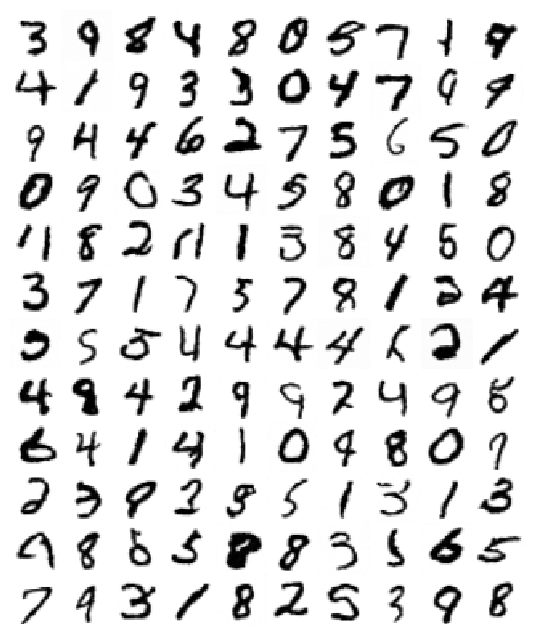

In [24]:
samples01 = ((samples + 1) / 2).clip(0, 1)
tools.show_images(samples01, cmap='binary', ncol=10)

In [25]:
# This cell tests the training loss of the trained denoising model

## In-painting: Conditional generation given known parts of a generated image

One of the benefits of diffusion-based generative model is the possibility to use a trained model for *conditional* generation of some parts (of an image) given known values of other parts. For example, given the top part of an image (like in the images shown below)
<img src="conditioning.png" width=400>
the model can generate samples which have the given values in the top part:
<img src="cond_samples.png" width=400>

In the cell below, your need to implement a function that generate samples conditioned on known parts of samples using your trained diffusion model.

Hints:
* There are different ways of performing this task but the most straightforward implementation contains a single for-loop similar to the standard reverse-diffusion process. The only difference is that the pixels of the known parts should converge to the known values by using an appropriate distribution to draw samples from.

* We recommend you to figure out the required math from [the original DDPM paper](https://arxiv.org/pdf/2006.11239.pdf).

* **In this exercise, we do not condition our generative model on the class information (the classes of digits). Therefore, we expect argument `labels` to be `None`. If you are interested in playing with a generative model conditioned on the class information, you can write your code to support this scenario. We expect no conditioning on classes in the grading tests.**


In [29]:
skip_training = False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

diffusion = Diffusion(1000)
model = UNet(
    img_channels=1,
    base_channels=32,
    time_emb_dim=32,
    num_classes=None,
)

tools.load_model(diffusion, '1_diffusion.pth', device)
tools.load_model(model, '1_unet.pth', device)

Model loaded from 1_diffusion.pth.
Model loaded from 1_unet.pth.


In [39]:
@torch.no_grad()
def inpaint(diffusion, model, images, mask_known, labels=None):
    """Generate samples conditioned on known parts of images.
    
    Args:
      diffusion (Diffusion): The descriptor of a diffusion model.
      model: A denoising model: model(x, t, labels) outputs a denoised version of input x.
      images of shape (batch_size, n_channels, H, W): Conditioning images.
      mask_known of shape (batch_size, 1, H, W): BoolTensor which specifies known pixels in images (marked as True).
      labels of shape (batch_size,): Classes of images, None for no conditioning on classes.
    
    Returns:
      x of shape (batch_size, n_channels, H, W): Generated samples (one sample per input image).
    """
    batch_size = images.shape[0]
    ret = torch.randn(images.shape).to(device)

    for t in reversed(range(0, diffusion.num_timesteps)):
        alpha_bar = torch.prod(1 - diffusion.betas[:t+1]).to(device)
        time_steps = torch.full((batch_size,), t, device=device, dtype=torch.long)
        noise = torch.randn_like(images).to(device) if t > 0 else torch.zeros_like(images).to(device)

        noisy_images = diffusion.forward(images, time_steps, noise)

        ret = noisy_images * mask_known + ret * ~mask_known

        output = model(ret, time_steps, labels)

        ret = 1 / torch.sqrt(1 - diffusion.betas[t]) * (ret - diffusion.betas[t] * output / torch.sqrt(1 - alpha_bar)) + torch.sqrt(diffusion.betas[t]) * noise

    return ret
    

Conditioning:


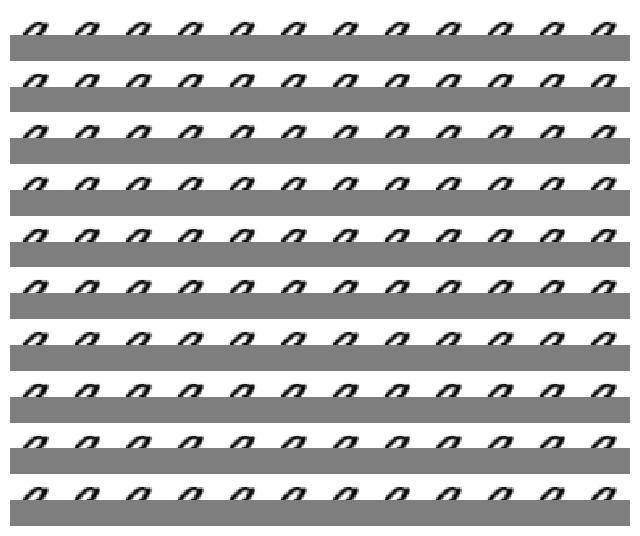

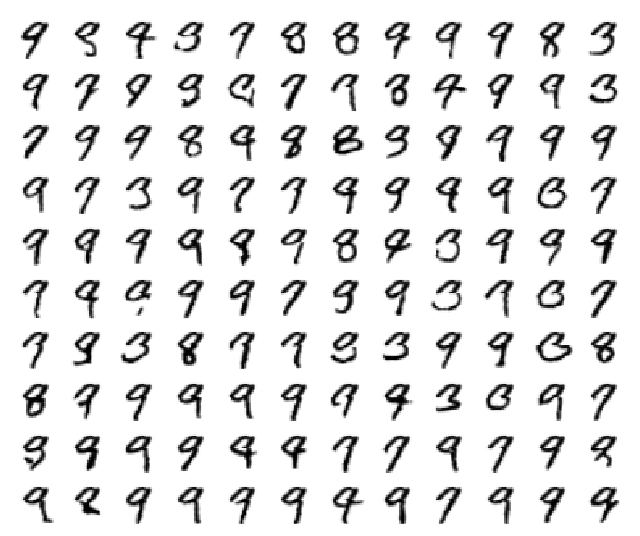

In [40]:
# This script uses your function to perform conditional generation
if not skip_training:
    with torch.no_grad():
        #(images, labels) = next(iter(trainloader))
        image, label = trainset[4]  # Select one image from the dataset
        images = image[None, 0].tile(120, 1, 1, 1)  # Copy the image to generate multiple samples
        images = images.to(device)
        labels = None
        (batch_size, _, H, W) = images.shape

        # mask out the bottom part of every image
        mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
        mask_known[:, :, :H//2, :] = 1
        images_known = images * mask_known

        samples01 = ((images_known + 1) / 2).clip(0, 1)
        print('Conditioning:')
        tools.show_images(samples01[:120], cmap='binary', ncol=12)

        samples = inpaint(diffusion, model, images_known, mask_known, labels=None)
        samples01 = ((samples + 1) / 2).clip(0, 1)
        tools.show_images(samples01[:120], cmap='binary', ncol=12)

In [334]:
@torch.no_grad()
def test_fid_score_inpaint(diffusion, model):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)
    
    (images, labels) = next(iter(trainloader))
    images = images.to(device)
    labels = None
    (batch_size, _, H, W) = images.shape

    # mask out the bottom part of every image
    mask_known = torch.zeros(batch_size, 1, H, W, dtype=torch.bool, device=device)
    mask_known[:, :, :H//2, :] = 1
    images_known = images * mask_known

    if not skip_training:
        model.eval()
        samples = inpaint(diffusion, model, images_known, mask_known, labels=None)
        torch.save(samples, '1_cond_samples.pth')

    else:
        samples = torch.load('1_cond_samples.pth', map_location=lambda storage, loc: storage)

    # Check conditioning
    mse = (samples - images)[mask_known].square().mean().item()
    print('MSE:', mse)
    assert mse < 1e-5, 'The known pixels should not change.'
    
    fdscore = fd.FDScore.pretrained(imsize=32)
    fdscore.to(device)
    score = fdscore.calculate(samples)
    print('FD score:', score)
    assert score < 3.5, 'The FD score should be below 3.5.'
    print('Success')

test_fid_score_inpaint(diffusion, model)

MSE: 7.02762645232724e-06
FD score: 1.8138920769014462
Success


<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this exercise, we trained a diffusion-based generative model and learned how to use the trained model for image in-painting.